In [35]:
import pandas as pd
import pickle as pkl
from collections import deque
import time
import brewer
import networkx as nx
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import importlib
from itertools import combinations
importlib.reload(brewer)

<module 'brewer' from 'd:\\Documentos\\BCC\\P8\\BD\\BrewER\\brewer\\__init__.py'>

In [36]:
# Change to raw dataset path
data = pd.read_csv("dataset.csv")

# Change to matches (dataframe with l_id and r_id pairs)
matches = pd.read_csv("matches.csv")

# Change to a pickled candidate pairs file (list of pairs)
with open(
    "candidates.pkl",
    "rb",
) as f:
    candidates = pkl.load(f)

In [ ]:
out_dir = Path("output")
out_dir.mkdir(parents=True, exist_ok=True)

In [37]:
G = nx.Graph()
G.add_edges_from(candidates)
blocks = [list(set(x)) for x in nx.connected_components(G)]

In [38]:
# If your matches aren't using l_id and r_id, or you have a different matching function change here
def matcher(l, r):
    return (
        ((matches["l_id"] == l) & (matches["r_id"] == r))
        | ((matches["l_id"] == r) & (matches["r_id"] == l))
    ).any()

In [39]:
# Change based on the query and resolution functions you specified on blender, for accurate comparison
def resolve(records):
    entity = {}
    entity["_id"] = records['_id'].mode()[0]
    entity["description"] = records['description'].mode()[0]
    entity["brand"] = records['brand'].mode()[0]
    entity["price"] = records["price"].min()
    entity["mp"] = records["mp"].mean()
    return entity

In [40]:
def batch(data, blocks):
    seen = set()
    matches_set = set()
    not_matches_set = set()
    result = []
    comparisons = 0

    for idx, row in data.iterrows():
        # Change if your id column is different
        root = row["_id"]
        to_analyze = deque([root])
        entity_cluster = set([root])

        if root in seen:
            continue

        while to_analyze:
            id = to_analyze.popleft()

            if id in seen:
                continue

            candidates = [block for block in blocks if id in block]
            if candidates:
                block = set().union(*candidates)
            else:
                block = set((id,))

            for candidate in block:
                if candidate in entity_cluster:
                    continue
                if id == candidate:
                    entity_cluster.add(candidate)
                    continue
                if (id, candidate) in matches_set:
                    entity_cluster.add(candidate)
                    to_analyze.append(candidate)
                    continue
                if (id, candidate) in not_matches_set:
                    continue
                comparisons += 1
                if matcher(id, candidate):
                    entity_cluster.add(candidate)
                    matches_set.add((id, candidate))
                    matches_set.add((candidate, id))
                    to_analyze.append(candidate)
                else:
                    not_matches_set.add((id, candidate))
                    not_matches_set.add((candidate, id))

        seen.update(entity_cluster)
        result.append(entity_cluster)
    return result, comparisons

In [41]:
start = time.time()

results, batch_comparisons = batch(data, blocks)

batch_elapsed_time = time.time() - start

In [42]:
# Change if your id column is different
resolved = pd.DataFrame([resolve(data[data["_id"].isin(entity)]) for entity in results])
# Change to the where query you used on blender, and the order by
batch_filtered = resolved[resolved["brand"] == "sony"].sort_values(
    "price", ascending=False
)
batch_filtered_pairs = set()
for group in (results[index] for index in batch_filtered.index):
    if len(group) > 1:
        batch_filtered_pairs.update([tuple(sorted(pair)) for pair in combinations(group, 2)])
    else:
        batch_filtered_pairs.add(tuple(sorted(group)))

In [ ]:
print("Batch finished")
print("Batch comparisons:", batch_comparisons)
print("Batch elapsed time:", batch_elapsed_time)
print("Batch emitted:", len(batch_filtered))
batch_dataframe = pd.DataFrame(
    [
        {"elapsed_time": 0, "comparisons": 0, "recall": 0, "precision": 0, "f1": 0, "correctness": 0},
        {"elapsed_time": batch_elapsed_time, "comparisons": batch_comparisons, "recall": 0, "precision": 0, "f1": 0, "correctness": 0},
        {"elapsed_time": batch_elapsed_time, "comparisons": batch_comparisons, "recall": 1, "precision": 1, "f1": 1, "correctness": 1}
    ]
)
batch_dataframe.to_csv(f'{out_dir}/batch_results.csv')

Batch finished
Batch comparisons: 34930
Batch elapsed time: 104.30956840515137
Batch emitted: 211


OSError: Cannot save file into a non-existent directory: 'output'

In [ ]:
# Change based on you matches file
def matcher_table(l, r):
      return (
        ((matches["l_id"] == l["table__id"]) & (matches["r_id"] == r["table__id"]))
        | ((matches["l_id"] == r["table__id"]) & (matches["r_id"] == l["table__id"]))
    ).any()

In [ ]:
brewer_start = 0
brewer_results = []
def listener(entity, cluster, comparisons):
    global brewer_start       

    if len(cluster) > 1:
        cluster_pairs = {tuple(sorted(pair)) for pair in combinations(cluster, 2)}
    else:
        cluster_pairs = set([tuple(sorted(cluster))])

    # Change based on the attribute you used to sort
    brewer_results.append({
        "elapsed_time": time.time() - brewer_start,
        "comparisons": comparisons,
        "order": entity["table_mp"],
        "tp": len(cluster_pairs & batch_filtered_pairs),
        "fp": len(cluster_pairs - batch_filtered_pairs),
    })

In [ ]:
# Create evaluation dataframe
def evaluate_results():
    brewer_dataframe = pd.DataFrame(brewer_results)

    if len(brewer_dataframe) > 0:
        prev = brewer_dataframe["order"].shift(1)
        # CHANGE < TO > IF ASC
        brewer_dataframe["correct_order"] = brewer_dataframe["order"].isna() |  (brewer_dataframe["order"] > prev) | np.isclose(brewer_dataframe["order"], prev, 1e-8)
        brewer_dataframe.loc[0, "correct_order"] = True

        brewer_dataframe["running_tp"] = brewer_dataframe["tp"].cumsum()
        brewer_dataframe["running_fp"] = brewer_dataframe["fp"].cumsum()
        brewer_dataframe["running_fn"] = (
            len(batch_filtered_pairs) - brewer_dataframe["running_tp"]
        )
        brewer_dataframe["running_correctness"] = brewer_dataframe[
            "correct_order"
        ].cumsum()

        brewer_dataframe["recall"] = (
            brewer_dataframe["running_tp"]
            / (brewer_dataframe["running_tp"] + brewer_dataframe["running_fn"])
        ).replace(np.nan, 0)
        brewer_dataframe["precision"] = (
            brewer_dataframe["running_tp"]
            / (brewer_dataframe["running_tp"] + brewer_dataframe["running_fp"])
        ).replace(np.nan, 0)
        brewer_dataframe["correctness"] = brewer_dataframe["running_correctness"] / (
            brewer_dataframe.index + 1
        )
        brewer_dataframe["f1"] = (
            2
            * (brewer_dataframe["precision"] * brewer_dataframe["recall"])
            / (brewer_dataframe["precision"] + brewer_dataframe["recall"])
        )

        brewer_dataframe.to_csv(f"{out_dir}/brewer_results.csv", index=False)

        return brewer_dataframe
    else:
        print("No results from brewer to evaluate.")

In [ ]:
def plot(x_col, x_label, batch_results, brewer_results):
    metrics = ["recall", "precision", "f1", "correctness"]

    batch_max_x = batch_results[x_col].max()
    brewer_max_x = brewer_results[x_col].max()
    maximum = max(batch_max_x, brewer_max_x,)
    xlim = maximum / 50

    for m in metrics:
        plt.figure(figsize=(7, 4))

        plt.plot(batch_results[x_col], batch_results[m], label="Batch", color="red")
        plt.annotate(
            f"{batch_results[m].max() * 100 : 0.2f}%",
            xy=(
                int(batch_results.iloc[int(batch_results[x_col].idxmax())][x_col]),
                batch_results[m].max(),
            ),
            xycoords="data",
        )

        plt.plot(brewer_results[x_col], brewer_results[m], label="BrewER", color="blue")
        plt.annotate(
            f"{brewer_results[m].max() * 100 : 0.2f}%",
            xy=(
                int(brewer_results.iloc[int(brewer_results[x_col].idxmax())][x_col]),
                brewer_results[m].max(),
            ),
            xycoords="data",
        )

        plt.xlabel(x_label)
        plt.ylabel(m.capitalize())
        plt.title(f"{m.capitalize()} vs {x_label}")
        plt.grid(True, alpha=0.3)
        plt.xlim([0 - xlim, maximum + xlim])
        plt.ylim([-0.05, 1.05])
        plt.legend(loc="center right")
        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

        png_path = out_dir / f"{m}_vs_{x_col}.png"
        plt.tight_layout()
        plt.savefig(png_path, dpi=300)
        print(f"Salvo: {png_path}")

In [ ]:
# Configure
brewer = (brewer.BrewER()
    .from_table(brewer.Table(data, blocks, matcher_table, "table", "_id"))
    .select(
        ("table._id", brewer.resolution_function.VOTE),
        ("table.description", brewer.resolution_function.VOTE),
        ("table.brand", brewer.resolution_function.VOTE),
        ("table.price", brewer.resolution_function.AVG),
        ("table.mp", brewer.resolution_function.AVG),
        order_by=("table.mp", brewer.SqlOrderBy.ASC),
    )
    .where('table.brand = "sony"')
    .subscribe(listener)
)

Running BrewER
BrewER Finished
Salvo: output\recall_vs_comparisons.png
Salvo: output\precision_vs_comparisons.png
Salvo: output\f1_vs_comparisons.png
Salvo: output\correctness_vs_comparisons.png
Salvo: output\recall_vs_elapsed_time.png
Salvo: output\precision_vs_elapsed_time.png
Salvo: output\f1_vs_elapsed_time.png
Salvo: output\correctness_vs_elapsed_time.png


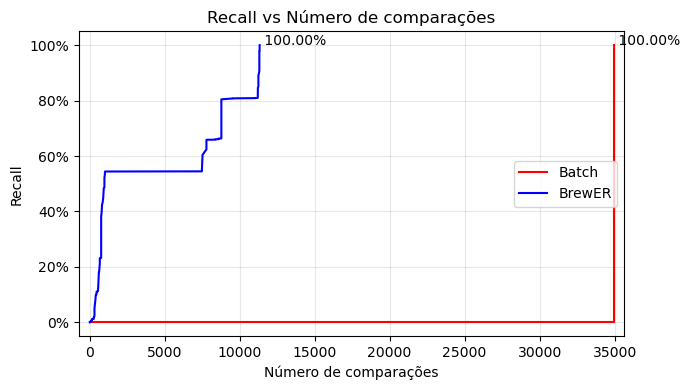

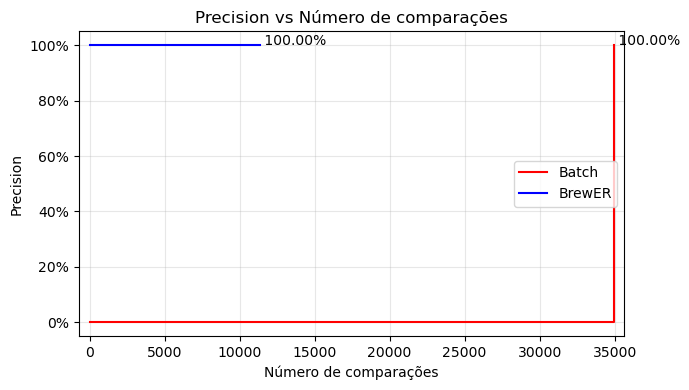

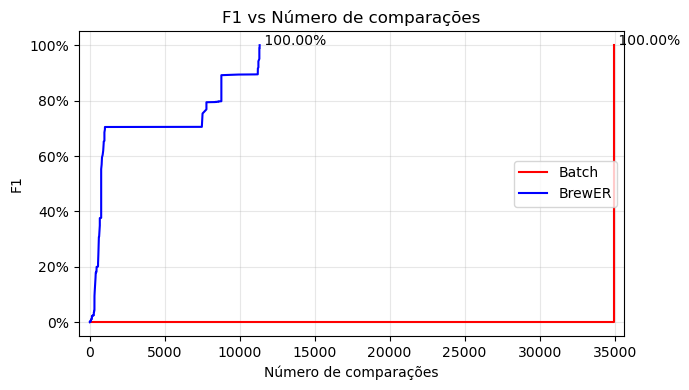

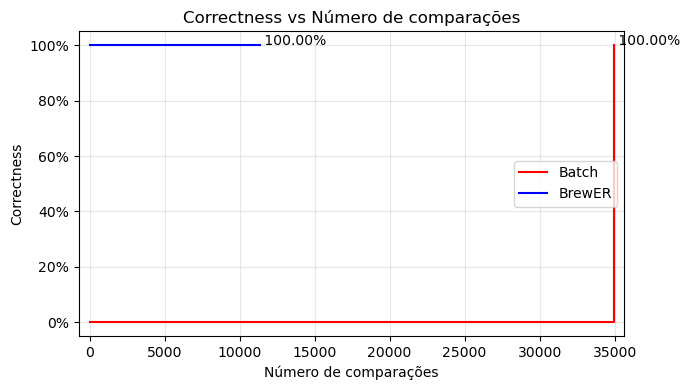

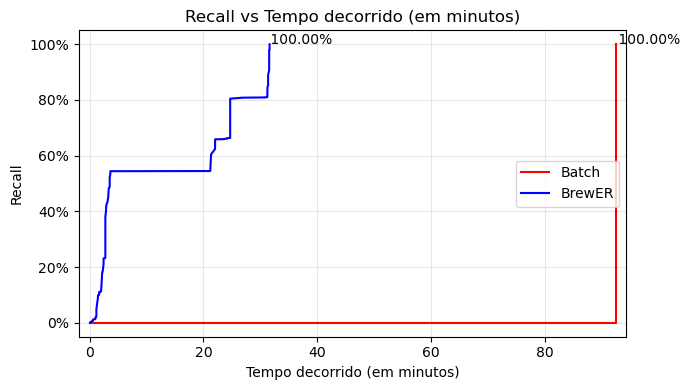

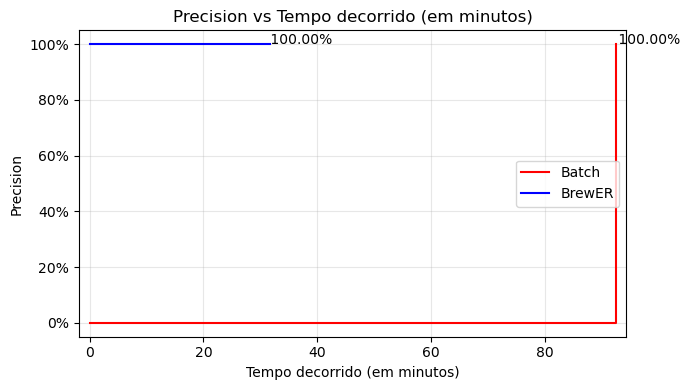

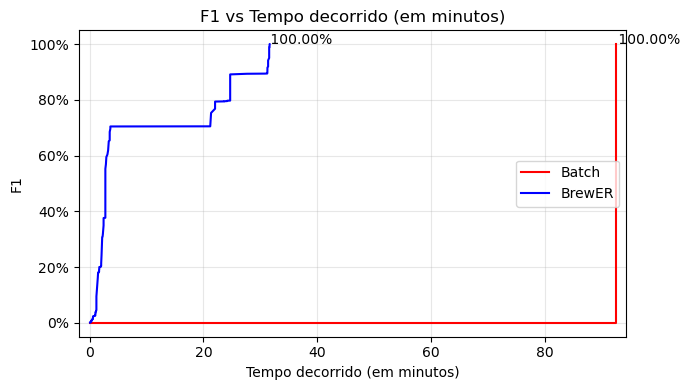

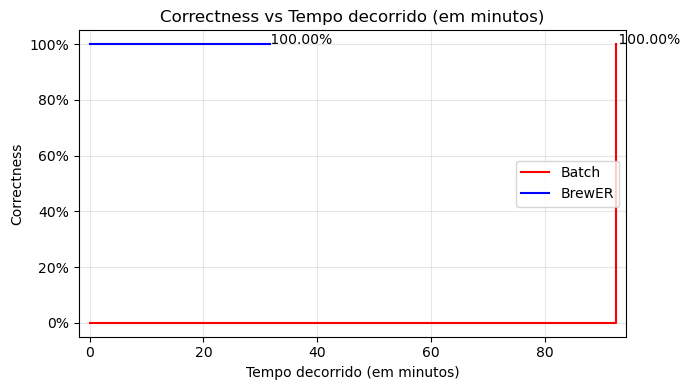

In [ ]:
print("Running BrewER")
brewer_start = time.time()
brewer_results = []
comparisons = 0
brewer.run(reset_matches=True)
brewer_dataframe = evaluate_results()
print("BrewER Finished")
plot("comparisons", "Número de comparações", batch_dataframe, brewer_dataframe)
plot("elapsed_time", "Tempo decorrido (em minutos)", batch_dataframe, brewer_dataframe)